# 图像拼接

In [1]:
# 导入需要的库
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1.利用特征点匹配实现

In [2]:
# 定义一个图像拼接类
class IMG_STITCH:
    
    # 初始化构造函数
    def __init__(self, list_image):
        self.list_img = []
        self.index = 1
        self.sruf = cv2.xfeatures2d.SURF_create()
        for image in list_image:
            img = cv2.imread(image)
            self.list_img.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #调换通道使原图颜色显示正常
        
    def calculate_kp_feature(self):
        # 计算图片的关键点和描述符
        self.dict_img = {}
        for img in self.list_img:
            (kp1, des1) = self.sruf.detectAndCompute(img, None)
            self.dict_img[img] = (kp1, des1)
    
    #定义图片匹配函数
    def Stitch(self, img1, img2):
        #plt.imshow(img2)
        print(self.index)
        kp1, des1 = self.sruf.detectAndCompute(img1, None)
        kp2, des2 = self.sruf.detectAndCompute(img2, None)
        
        kp1 = np.float32([kp.pt for kp in kp1]) # 得到的点需要进一步转换才能使用
        kp2 = np.float32([kp.pt for kp in kp2]) # 得到的点需要进一步转换才能使用
        
        # 基于最近邻和随机取样一致性得到一个单应性矩阵
        matcher = cv2.BFMatcher()
        rawMatches = matcher.knnMatch(des1, des2, 2)
        matches = []
        
        for i,(m,n) in enumerate(rawMatches):
            if(m.distance<0.75*n.distance):
                matches.append(m)
        # for m in rawMatches:
        #     if len(m) == 2 and m[0].distance < ratio * m[1].distance:
        #         matches.append((m[0].queryIdx, m[0].trainIdx))
        kpsA = np.float32([kp1[m.queryIdx] for m in matches]).reshape(-1,1,2) # 使用np.float32转化列表
        kpsB = np.float32([kp2[m.trainIdx] for m in matches]).reshape(-1,1,2)
        
        #通过两个图像的关键点计算变换矩阵
        (M, status) = cv2.findHomography(kpsA, kpsB, cv2.RANSAC, 4.0)

        img_wrap = cv2.warpPerspective(img2, np.linalg.inv(M), (img1.shape[1] + img2.shape[1], img1.shape[0]))
        plt.imshow(img_wrap)
        
        # 拉伸图像以填充整个拼接图片
        # rows,cols=img1.shape[:2]

        # for col in range(0,cols):
        #     if img1[:, col].any() and img_wrap[:, col].any():#开始重叠的最左端
        #         left = col
        #         break
        # for col in range(cols-1, 0, -1):
        #     if img1[:, col].any() and img_wrap[:, col].any():#重叠的最右一列
        #         right = col
        #         break

        # res = np.zeros([rows, cols, 3], np.uint8)
        # for row in range(0, rows):
        #     for col in range(0, cols):
        #         if not img1[row, col].any():#如果没有原图，用旋转的填充
        #             res[row, col] = img_wrap[row, col]
        #         elif not img_wrap[row, col].any():
        #             res[row, col] = img1[row, col]
        #         else:
        #             srcImgLen = float(abs(col - left))
        #             testImgLen = float(abs(col - right))
        #             alpha = srcImgLen / (srcImgLen + testImgLen)
        #             res[row, col] = np.clip(img1[row, col] * (1-alpha) + img_wrap[row, col] * alpha, 0,255)
        
        img_wrap[0:img1.shape[0], 0:img1.shape[1]]= img1
        
        self.index = self.index +1
        
        # 判断是否拼接完毕
        if self.index < len(self.list_img): #如果拼接的图片数小于图片列表长度，则继续递归调用该函数
            self.Stitch(img_wrap, self.list_img[self.index]) #将该次拼接的结果和下一张图片进行拼接
        else: #若长度等于图片列表长度，则返回最终的拼接结果
            plt.imshow(img_wrap)
            return img_wrap

    # 定义总匹配函数
    def Stitch_All(self):
        img_result = self.Stitch(self.list_img[0], self.list_img[1])
        return img_result

1


True

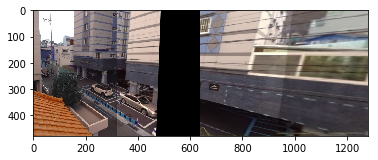

In [14]:
list_img = ['11.jpg', '12.jpg']
stitch = IMG_STITCH(list_img)
img_1 = stitch.Stitch_All()
cv2.imwrite('12.jpg', img_1)

2.5

1


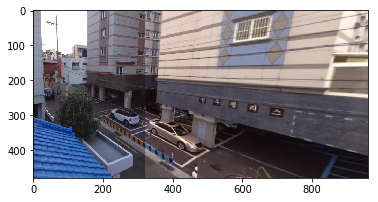

In [6]:
list_img = ['S2.jpg', 'S3.jpg']
stitch = IMG_STITCH(list_img)
img_1 = stitch.Stitch_All()

In [121]:
list_img = ['4.jpg',"S.jpg"]
stitch = IMG_STITCH(list_img)
img_2 = stitch.Stitch_All()
cv2.imwrite('4.jpg', img_2)

error: OpenCV(3.4.2) c:\projects\opencv-python\opencv\modules\imgproc\src\color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'cv::CvtHelper<struct cv::Set<3,4,-1>,struct cv::Set<3,4,-1>,struct cv::Set<0,2,5>,2>::CvtHelper'


## 2.直接调用opencv中的方法实现

In [25]:
# 加载原始图片
img1 = cv2.imread("S1.jpg")
img2 = cv2.imread("S2.jpg")
img3 = cv2.imread("S3.jpg")
img4 = cv2.imread("S5.jpg")
img5 = cv2.imread("S6.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) #调换通道使原图颜色显示正常
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) #调换通道使原图颜色显示正常
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB) #调换通道使原图颜色显示正常
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB) #调换通道使原图颜色显示正常
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB) #调换通道使原图颜色显示正常
stitcher = cv2.createStitcher(False)
(_result, pano) = stitcher.stitch((img1, img2, img3, img4, img5))

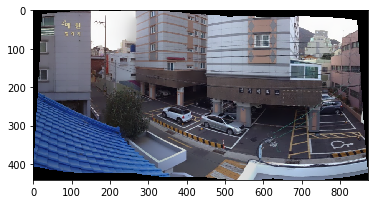

In [26]:
plt.imshow(pano)

[<DMatch 0000021DFBA8D4D0>, <DMatch 0000021DA0262B70>, <DMatch 0000021DFE511FD0>, <DMatch 0000021DA03E1FB0>, <DMatch 0000021DFBA8DDB0>, <DMatch 0000021DA0262DD0>, <DMatch 0000021DFBA8DB70>, <DMatch 0000021DA02629B0>, <DMatch 0000021DFE5116D0>, <DMatch 0000021DFF2A23D0>, <DMatch 0000021DA03E1CD0>, <DMatch 0000021DA0262FD0>, <DMatch 0000021DFE511870>, <DMatch 0000021DFE5118B0>, <DMatch 0000021DFF2A2270>, <DMatch 0000021DA03E1070>, <DMatch 0000021DFBA8D2B0>, <DMatch 0000021DFF2A2730>, <DMatch 0000021DFBA8D150>, <DMatch 0000021DFE511330>, <DMatch 0000021DA03E1D50>, <DMatch 0000021DFE511510>, <DMatch 0000021DFF2A2D50>, <DMatch 0000021DFE511570>, <DMatch 0000021DA068FEF0>, <DMatch 0000021DFE511C70>, <DMatch 0000021DFF2A2930>]


e:\python36\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


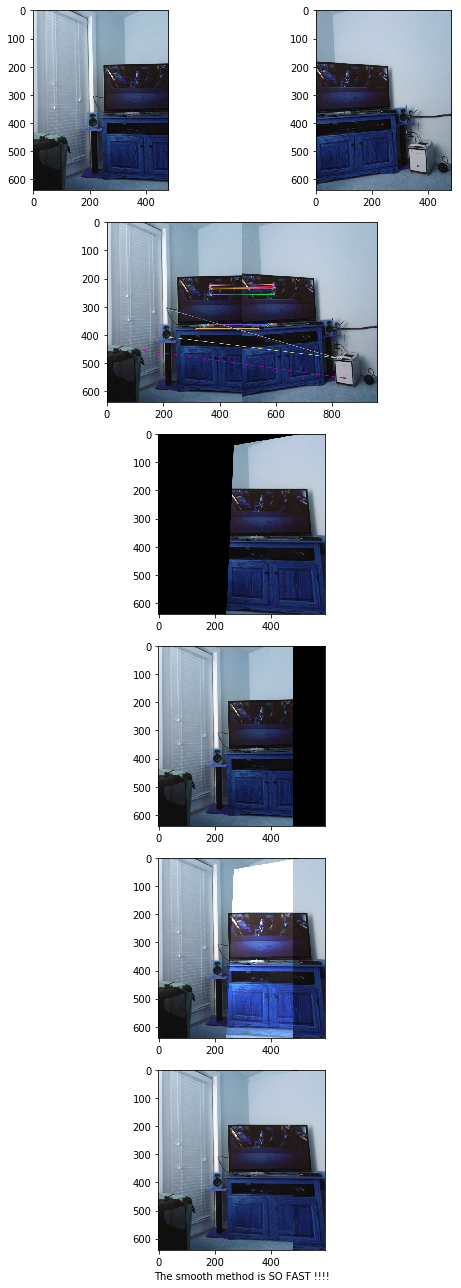

In [94]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

GOOD_POINTS_LIMITED = 0.99
src = '1.jpg'
des = '2.jpg'

img1_3 = cv.imread(src,1)# 基准图像
img2_3 = cv.imread(des,1)# 拼接图像

orb = cv.ORB_create()
kp1, des1 = orb.detectAndCompute(img1_3,None)
kp2, des2 = orb.detectAndCompute(img2_3,None)

bf = cv.BFMatcher.create()

matches = bf.match(des1,des2)

matches = sorted(matches, key = lambda x:x.distance)

goodPoints =[]
for i in range(len(matches)-1):
    if matches[i].distance < GOOD_POINTS_LIMITED * matches[i+1].distance:
        goodPoints.append(matches[i])

# goodPoints = matches[:20] if len(matches) > 20   else matches[:]
print(goodPoints)

img3 = cv.drawMatches(img1_3,kp1,img2_3,kp2,goodPoints, flags=2,outImg=None )

src_pts = np.float32([kp1[m.queryIdx].pt for m in goodPoints]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in goodPoints]).reshape(-1, 1, 2)

M, mask = cv.findHomography( dst_pts,src_pts, cv.RHO)

# 获取原图像的高和宽
h1,w1,p1 = img2_3.shape
h2,w2,p2 = img1_3.shape

h = np.maximum(h1,h2)
w = np.maximum(w1,w2)

_movedis = int(np.maximum(dst_pts[0][0][0],src_pts[0][0][0]))
imageTransform = cv.warpPerspective(img2_3,M,(w1+w2-_movedis,h))

M1 = np.float32([[1, 0, 0], [0, 1, 0]])
h_1,w_1,p = img1_3.shape
dst1 = cv.warpAffine(img1_3,M1,(w1+w2-_movedis, h))

dst = cv.add(dst1,imageTransform)
dst_no = np.copy(dst)

dst_target = np.maximum(dst1,imageTransform)

fig = plt.figure(tight_layout=True, figsize=(8, 18))
gs = gridspec.GridSpec(6, 2)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(img1_3)
ax = fig.add_subplot(gs[0, 1])
ax.imshow(img2_3)
ax = fig.add_subplot(gs[1, :])
ax.imshow(img3)
ax = fig.add_subplot(gs[2, :])
ax.imshow(imageTransform)
ax = fig.add_subplot(gs[3, :])
ax.imshow(dst1)
ax = fig.add_subplot(gs[4, :])
ax.imshow(dst_no)
ax = fig.add_subplot(gs[5, :])
ax.imshow(dst_target)
ax.set_xlabel('The smooth method is SO FAST !!!!')
plt.show()